# The Variational Quantum Eigensolver

VQE 1234

 One:   One core concept: Variational principle <br/>
 Two:   Two subroutine: Quantum and Classical <br/>
Three:  Three steps: Ansatz preparation, measure expectation and optimization <br/>
And........  For Success!

In [1]:
from qiskit import version
version._get_qiskit_versions()

{'qiskit': '0.11.0',
 'qiskit-terra': '0.8.2',
 'qiskit-ignis': '0.1.1',
 'qiskit-aer': '0.2.3',
 'qiskit-ibmq-provider': '0.3.0',
 'qiskit-aqua': '0.5.2'}

## VQE in nutshell: eigenvalue of pauli Z matrix


#### Import package

In [2]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
import numpy as np

### Step 1: Ansatz preparation

In [3]:
qr = QuantumRegister(1, 'q')
def vqe_ansatz(theta):
    var_circ= QuantumCircuit(qr)
    var_circ.ry(theta,qr)
    return var_circ

### Step 2: Measure Expectation value (qasm backend)

In [4]:
### Select simulator
QC_simulator = Aer.get_backend('qasm_simulator')

# Define number of measurments shots
sample_shots=20000

cr = ClassicalRegister(1, 'c')
def expval(parameter):
    
    # Call ansatz
    circ_in=vqe_ansatz(parameter)
    
    # Measure in z basis
    meas = QuantumCircuit(qr, cr)
    meas.barrier(qr)
    meas.measure(qr,cr)
    vqe=circ_in+meas
    
    # Compile and execute
    job_sim = execute(vqe, QC_simulator,shots=sample_shots)
    result_sim = job_sim.result().get_counts()
    
    # Calculate expectation
    P_0=result_sim.get('0',0)/sample_shots
    P_1=result_sim.get('1',0)/sample_shots
    
    return P_0-P_1

#### Test yout expectation value

In [5]:
test_expval=expval(0.5)
print("Expectation value : {}".format(test_expval))

Expectation value : 0.8786


### Step 3: Optimization

Since in this case, we have only one parameter $\theta$, we can calculate the expectation value for $\theta \in [0,2\pi]$

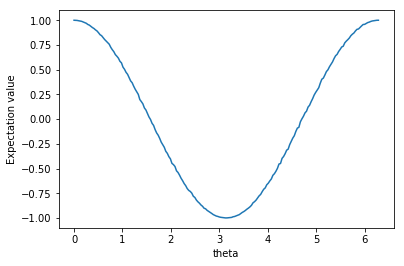

In [6]:
theta_range = np.linspace(0.0, 2 * np.pi, 200)
vqe_result=[expval(params) for params in theta_range]

import matplotlib.pyplot as plt
%matplotlib inline 
plt.xlabel('theta')
plt.ylabel('Expectation value')
plt.plot(theta_range, vqe_result)
plt.show()

In [7]:
print("The lowest eigenvalue: {0} \t corresponding parameters: {1}".format(min(vqe_result),theta_range[vqe_result.index(min(vqe_result))]))

The lowest eigenvalue: -0.9998 	 corresponding parameters: 3.1258057558330608
